In [1]:
import os
os.chdir('../')

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *

Loading imports


In [3]:
torch.cuda.set_device(3)

## Load Model

In [4]:
class Transfusion(nn.Module):
    def __init__(self, channels, ks=7):
        super().__init__()
        layers = []
        ks = [ks]*len(channels) if isinstance(ks, int) else ks
        l_args = zip(channels, ks)
        for (c_in,c_out),k in l_args: layers += [ConvLayer(c_in, c_out, ks=k), nn.MaxPool2d(3, stride=2, padding=1)]
        self.body = nn.Sequential(*layers)
        self.head = nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(channels[-1][-1], 6)
        ])
        
    def forward(self, x):
        return self.head(self.body(x))

In [5]:
# model = xresnet18(c_in=4)

In [6]:
def t_large():
    chs = [(3,32), (32, 64), (64, 128), (128, 256), (256, 512)]
    return Transfusion(chs, ks=7)

In [7]:
def t_tiny():
    chs = [(3,64), (64, 128), (128, 256), (256, 512)]
    return Transfusion(chs, ks=5)

In [8]:
def t_med():
    chs = [(3,32), (32, 64), (64, 128), (128, 256), (256, 512)]
    return Transfusion(chs, ks=(7,3,3,5,5))

In [9]:
m = t_tiny()

In [10]:
# m = xresnet18(c_out=6) # 2:50 per epoch

In [11]:
name = 'baseline_any_transfusion'

In [12]:
dbch = get_data(512, 128, splits=Meta.splits_any)
learn = get_learner(dbch, m)

In [17]:
learn.model

Transfusion(
  (body): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ConvLayer(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ConvLayer(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): ConvLayer(
      (0): Conv2d

## Training

In [14]:
# learn.lr_find()

In [15]:
do_fit(learn, 20, 4e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.276426,0.293246,0.886073,0.777857,03:43
1,0.243228,0.251806,0.905191,0.846166,03:34
2,0.228647,0.248411,0.908317,0.832314,03:39
3,0.216529,0.215589,0.921741,0.857502,03:37
4,0.208653,0.255787,0.906282,0.812422,03:38
5,0.201520,0.221462,0.920951,0.846166,03:36
6,0.196041,0.206554,0.926866,0.869739,03:38
7,0.194461,0.200313,0.929272,0.874268,03:37
8,0.190846,0.199738,0.929170,0.876890,03:36
9,0.185453,0.200896,0.927846,0.867991,03:37


In [13]:
learn.dls = get_data(256, 224, splits=Meta.splits_any)
learn.load(f'runs/{name}-1')

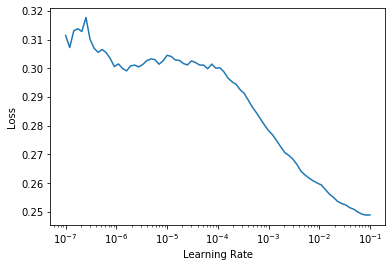

In [23]:
learn.lr_find()

In [14]:
do_fit(learn, 20, 4e-3)
learn.save(f'runs/{name}-2')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.192784,0.199609,0.928120,0.872414,08:25
1,0.180281,0.191757,0.931810,0.876228,08:18
2,0.178847,0.187907,0.934247,0.883406,08:20
3,0.173089,0.187105,0.934044,0.880228,08:19
4,0.170719,0.185059,0.934746,0.880360,08:18
5,0.168283,0.182840,0.936388,0.883380,08:20
6,0.164898,0.185209,0.936083,0.887300,08:19
7,0.162203,0.182037,0.936052,0.884068,08:19
8,0.157728,0.186512,0.935333,0.884227,08:18
9,0.153338,0.186087,0.936278,0.884651,08:20


In [17]:
learn.dls = get_data(512, 256, splits=Meta.splits)
do_fit(learn, 2, 5e-4)
learn.save(f'runs/{name}-3-full')

ValueError: invalid literal for int() with base 10: 'Modality'

## Submission

In [6]:
learn.load(f'runs/{name}-3-full')
sub_fn = f'subm/{name}'

In [8]:
learn.dls = get_test_data(Meta.df_tst, bs=512, sz=None, tst_dir='tst_jpg256')

In [9]:
ob = learn.dls.one_batch()

In [10]:
preds,targs = learn.get_preds()

In [11]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [12]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:02<00:00, 10.0MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [13]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 13768428,
 'totalBytes': 27277209,
 'date': '2019-12-12T18:13:15.577Z',
 'description': 'baseline_any_xresnet18',
 'errorDescription': None,
 'fileName': 'baseline_any_xresnet18.csv',
 'publicScore': '0.78783',
 'privateScore': '0.07677',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/13768428/13768428.raw'}